In [28]:
from gensim.models import Word2Vec
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import enchant
from tqdm import tqdm
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from scipy.stats import spearmanr
from scipy.spatial import procrustes
from statistics import mean
from SSE import SpreadIndexCalculator, tfidf, WordFrequencyCalculator, find_most_similar_words_per_year, LocalNeighborsMeasure, calculate_jaccard_similarity

Load file & fine-tuned models.

In [2]:
tokens = np.load('tokens_per_year_bigrams2.npy',allow_pickle='FALSE').item()

In [3]:
models = {}  
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
for year in years:
    file_name = f"word2vec_{year}_sg17.model"
    
    if os.path.exists(file_name):
        loaded_model = Word2Vec.load(file_name)
        models[year] = loaded_model
        print(f"Model for {year} successfully uploaded.")
    else:
        print(f"Model for {year} not found: {file_name}.")

Model for 2006 successfully uploaded.
Model for 2007 successfully uploaded.
Model for 2008 successfully uploaded.
Model for 2009 successfully uploaded.
Model for 2010 successfully uploaded.
Model for 2011 successfully uploaded.
Model for 2012 successfully uploaded.
Model for 2013 successfully uploaded.
Model for 2014 successfully uploaded.
Model for 2015 successfully uploaded.
Model for 2016 successfully uploaded.
Model for 2017 successfully uploaded.
Model for 2018 successfully uploaded.
Model for 2019 successfully uploaded.
Model for 2020 successfully uploaded.
Model for 2021 successfully uploaded.
Model for 2022 successfully uploaded.
Model for 2023 successfully uploaded.


In [4]:
# SAVE THE VECTORS:
ft_vectors = {}
for year, model in models.items():
    word_vectors = model.wv  
    ft_vectors[year] = word_vectors

Compute pairwise cosine similarity between 'circular_economy' embeddings.

In [5]:
embeddings_list = []
for year, word_vectors in ft_vectors.items():
    try:
        embedding = np.array(word_vectors['circular_economy']).reshape(1, -1)
        embeddings_list.append((year, embedding))
    except KeyError:
        print(f"'circular_economy' not in {year}")

# Compute pairwise similarity between consecutive years
years = []
similarities = []
for i in range(len(embeddings_list)-1):
    year1, emb1 = embeddings_list[i]
    year2, emb2 = embeddings_list[i+1]
    
    # Compute similarity score
    similarity = cosine_similarity(emb1, emb2)[0][0]
    similarities.append(similarity)
    years.append(f"{year1}-{year2}")
    
    print(f'Similarity bewteen {year1} and {year2}: {similarity}')
    
    #global measure -> hamilton

Similarity bewteen 2006 and 2007: 0.6487202644348145
Similarity bewteen 2007 and 2008: 0.5684981346130371
Similarity bewteen 2008 and 2009: 0.5387462377548218
Similarity bewteen 2009 and 2010: 0.5935713052749634
Similarity bewteen 2010 and 2011: 0.5769169330596924
Similarity bewteen 2011 and 2012: 0.6341648101806641
Similarity bewteen 2012 and 2013: 0.5827500224113464
Similarity bewteen 2013 and 2014: 0.5902754068374634
Similarity bewteen 2014 and 2015: 0.566437304019928
Similarity bewteen 2015 and 2016: 0.5919016599655151
Similarity bewteen 2016 and 2017: 0.6421928405761719
Similarity bewteen 2017 and 2018: 0.6779855489730835
Similarity bewteen 2018 and 2019: 0.6921951174736023
Similarity bewteen 2019 and 2020: 0.6757103800773621
Similarity bewteen 2020 and 2021: 0.6655546426773071
Similarity bewteen 2021 and 2022: 0.6477724313735962
Similarity bewteen 2022 and 2023: 0.7521069049835205


In [6]:
# compute the spearman correlation to observe significant change in data
median_years = [(float(year.split('-')[0]) + float(year.split('-')[1])) / 2 for year in years]
corr, p_value = spearmanr(median_years, similarities)
print(f"Spearman Correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman Correlation: 0.674
P-value: 0.003


In [7]:
lsm = LocalNeighborsMeasure(models)
similarity_results = lsm.calculate_consecutive_year_similarity('circular_economy', 2006, 2024)

for years, similarity in similarity_results.items():
    print(f"Local neighborhood similarity measure for 'circular_economy' between {years}: {similarity}")

Local neighborhood similarity measure for 'circular_economy' between 2006-2007: 0.9803900718688965
Local neighborhood similarity measure for 'circular_economy' between 2007-2008: 0.9782798290252686
Local neighborhood similarity measure for 'circular_economy' between 2008-2009: 0.9661560654640198
Local neighborhood similarity measure for 'circular_economy' between 2009-2010: 0.9692249298095703
Local neighborhood similarity measure for 'circular_economy' between 2010-2011: 0.9654086828231812
Local neighborhood similarity measure for 'circular_economy' between 2011-2012: 0.9784733057022095
Local neighborhood similarity measure for 'circular_economy' between 2012-2013: 0.9806969165802002
Local neighborhood similarity measure for 'circular_economy' between 2013-2014: 0.9603762030601501
Local neighborhood similarity measure for 'circular_economy' between 2014-2015: 0.9609227180480957
Local neighborhood similarity measure for 'circular_economy' between 2015-2016: 0.9800170660018921
Local neig

In [8]:
years_avg = [(int(year.split('-')[0]) + int(year.split('-')[1])) / 2 for year in similarity_results.keys()]
similarities = list(similarity_results.values())

# Spearman correlation
corr, p_value = spearmanr(years_avg, similarities)

print(f"Spearman Correlation: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

Spearman Correlation: 0.725
P-value: 0.001


Compute the similarity matrix between 'circular_economy' vector representations in time.

In [9]:
n = len(embeddings_list)
years = [pair[0] for pair in embeddings_list] 
similarity_df = pd.DataFrame(index=years, columns=years)

for i in range(n):
    for j in range(n):
        year1, emb1 = embeddings_list[i]
        year2, emb2 = embeddings_list[j]
        if i == j: 
            similarity_df.at[year1, year2] = 1
        else:
            similarity = cosine_similarity(emb1, emb2)[0][0]
            similarity_df.at[year1, year2] = similarity
            
similarity_df = similarity_df.astype(float)

In [10]:
similarity_df

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
2006,1.000000,0.648720,0.616918,0.599614,0.594896,0.564558,0.642994,0.588207,0.626969,0.570851,0.581119,0.601447,0.528220,0.460635,0.448678,0.511764,0.394833,0.326425
2007,0.648720,1.000000,0.568498,0.614999,0.495287,0.562688,0.589930,0.624428,0.634870,0.506763,0.617540,0.516510,0.573888,0.520344,0.487251,0.489726,0.415559,0.373149
2008,0.616918,0.568498,1.000000,0.538746,0.500773,0.551959,0.607759,0.567165,0.605264,0.478366,0.550914,0.499546,0.531703,0.522294,0.499534,0.547747,0.419664,0.341966
2009,0.599614,0.614999,0.538746,1.000000,0.593571,0.548712,0.590627,0.607014,0.546704,0.473404,0.545537,0.457504,0.469566,0.434400,0.495413,0.489819,0.426382,0.388154
2010,0.594896,0.495287,0.500773,0.593571,1.000000,0.576917,0.532683,0.588443,0.559128,0.422484,0.515661,0.419909,0.388010,0.383675,0.358425,0.450207,0.396061,0.303220
2011,0.564558,0.562688,0.551959,0.548712,0.576917,1.000000,0.634165,0.572844,0.561259,0.439460,0.576206,0.527337,0.520765,0.500907,0.551684,0.516817,0.441926,0.365155
2012,0.642994,0.589930,0.607759,0.590627,0.532683,0.634165,1.000000,0.582750,0.614827,0.532269,0.619348,0.577151,0.510739,0.510530,0.526137,0.529942,0.405934,0.334163
2013,0.588207,0.624428,0.567165,0.607014,0.588443,0.572844,0.582750,1.000000,0.590275,0.491287,0.646386,0.483034,0.525886,0.457288,0.464300,0.540232,0.398064,0.362565
2014,0.626969,0.634870,0.605264,0.546704,0.559128,0.561259,0.614827,0.590275,1.000000,0.566437,0.656257,0.594148,0.637008,0.567030,0.552449,0.647026,0.523252,0.435548
2015,0.570851,0.506763,0.478366,0.473404,0.422484,0.439460,0.532269,0.491287,0.566437,1.000000,0.591902,0.551150,0.569080,0.559225,0.481272,0.568480,0.467255,0.411313


In [11]:
max_value = similarity_df[similarity_df < 1].max().max()
print(f"Max similarity value: {max_value}")

min_value = similarity_df[similarity_df > 0].min().min()
print(f"Min similarity value: {min_value}")

max_pairs = [(i, j) for i in similarity_df.columns for j in similarity_df.index if similarity_df.at[j, i] == max_value]
print(f"Pairs of maximum similarity: {max_pairs}")

min_pairs = [(i, j) for i in similarity_df.columns for j in similarity_df.index if similarity_df.at[j, i] == min_value]
print(f"Pairs of minimum similarity: {min_pairs}")

Max similarity value: 0.7521069049835205
Min similarity value: 0.30321964621543884
Pairs of maximum similarity: [('2022', '2023'), ('2023', '2022')]
Pairs of minimum similarity: [('2010', '2023'), ('2023', '2010')]


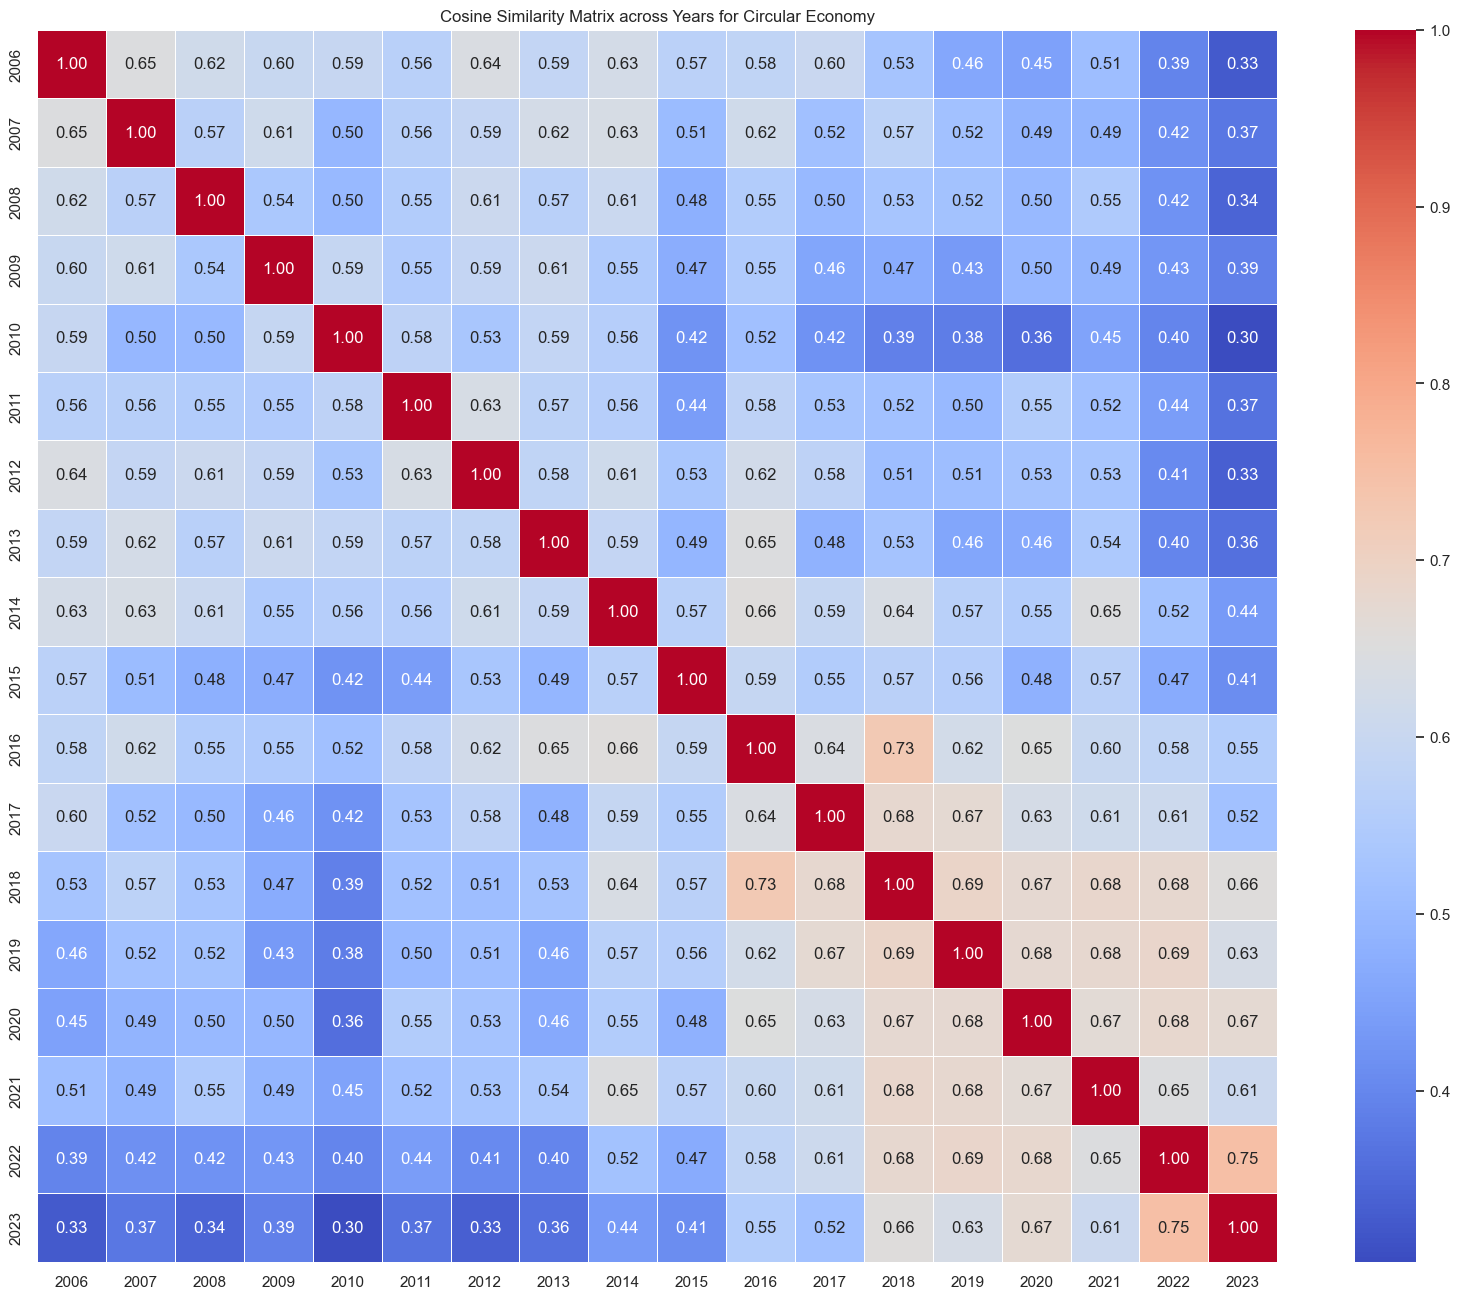

In [68]:
sns.set_theme(style="dark")

# Creazione della heatmap con il DataFrame `similarity_df`
plt.figure(figsize=(20, 16))  # Modifica le dimensioni se necessario per adattarle al tuo schermo
heatmap = sns.heatmap(similarity_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Cosine Similarity Matrix across Years for Circular Economy')
plt.show()

In [12]:
# compute context similarity
similar_words_per_year = lsm.get_similar_neighbors('circular_economy')

In [13]:
j_similarities = {}

years = sorted(similar_words_per_year.keys())

for i in range(len(years)-1):
    year_i = years[i]
    year_j = years[i + 1]
    
    set_i = set(similar_words_per_year[year_i])
    set_j = set(similar_words_per_year[year_j])
    
    jaccard_similarity = calculate_jaccard_similarity(set_i, set_j)
    
    j_similarities[(year_i, year_j)] = jaccard_similarity

for years, similarity in j_similarities.items():
    print(f"Jaccard similarity between {years[0]} & {years[1]}: {similarity:.4f}")

Jaccard similarity between 2006 & 2007: 0.3333
Jaccard similarity between 2007 & 2008: 0.2766
Jaccard similarity between 2008 & 2009: 0.2500
Jaccard similarity between 2009 & 2010: 0.4286
Jaccard similarity between 2010 & 2011: 0.3333
Jaccard similarity between 2011 & 2012: 0.3043
Jaccard similarity between 2012 & 2013: 0.3333
Jaccard similarity between 2013 & 2014: 0.1765
Jaccard similarity between 2014 & 2015: 0.1538
Jaccard similarity between 2015 & 2016: 0.3043
Jaccard similarity between 2016 & 2017: 0.3636
Jaccard similarity between 2017 & 2018: 0.3333
Jaccard similarity between 2018 & 2019: 0.3043
Jaccard similarity between 2019 & 2020: 0.3043
Jaccard similarity between 2020 & 2021: 0.4286
Jaccard similarity between 2021 & 2022: 0.5385
Jaccard similarity between 2022 & 2023: 0.6216


In [16]:
# jaccart similarity per anni diversi
j_similarities_across_years = {}
years = sorted(similar_words_per_year.keys())

for i in range(len(years)):
    for j in range(i+1, len(years)):
        year_i = years[i]
        year_j = years[j]

        set_i = set(similar_words_per_year[year_i])
        set_j = set(similar_words_per_year[year_j])

        jaccard_similarity = calculate_jaccard_similarity(set_i, set_j)

        j_similarities_across_years[(year_i, year_j)] = jaccard_similarity

for years, similarity in j_similarities_across_years.items():
    print(f"Jaccard similarity between {years[0]} & {years[1]}: {similarity:.4f}")

Jaccard similarity between 2006 & 2007: 0.3333
Jaccard similarity between 2006 & 2008: 0.2500
Jaccard similarity between 2006 & 2009: 0.2500
Jaccard similarity between 2006 & 2010: 0.2245
Jaccard similarity between 2006 & 2011: 0.2766
Jaccard similarity between 2006 & 2012: 0.3043
Jaccard similarity between 2006 & 2013: 0.2000
Jaccard similarity between 2006 & 2014: 0.2500
Jaccard similarity between 2006 & 2015: 0.2000
Jaccard similarity between 2006 & 2016: 0.2000
Jaccard similarity between 2006 & 2017: 0.2500
Jaccard similarity between 2006 & 2018: 0.1538
Jaccard similarity between 2006 & 2019: 0.1321
Jaccard similarity between 2006 & 2020: 0.1538
Jaccard similarity between 2006 & 2021: 0.2000
Jaccard similarity between 2006 & 2022: 0.2000
Jaccard similarity between 2006 & 2023: 0.1321
Jaccard similarity between 2007 & 2008: 0.2766
Jaccard similarity between 2007 & 2009: 0.3333
Jaccard similarity between 2007 & 2010: 0.3043
Jaccard similarity between 2007 & 2011: 0.3636
Jaccard simil

In [25]:
max_jsimilarity = max(j_similarities_across_years.values())
min_jsimilarity = min(j_similarities_across_years.values())
avg_jsimilarity = mean(j_similarities_across_years.values())

max_similarity_pairs = []
min_similarity_pairs = []

for pair, similarity in j_similarities_across_years.items():
    if similarity == max_jsimilarity:
        max_similarity_pairs.append(pair)
    if similarity == min_jsimilarity:
        min_similarity_pairs.append(pair)

print(f"Maximum Jaccard similarity across years: {max_jsimilarity:.4f}, Pairs: {max_similarity_pairs}")
print(f"Minimum Jaccard similarity across years: {min_jsimilarity:.4f}, Pairs: {min_similarity_pairs}")
print(f"Average Jaccard similarity across years: {avg_jsimilarity:.4f}")

Maximum Jaccard similarity across years: 0.6216, Pairs: [('2022', '2023')]
Minimum Jaccard similarity across years: 0.1321, Pairs: [('2006', '2019'), ('2006', '2023'), ('2008', '2019'), ('2008', '2023'), ('2009', '2016'), ('2010', '2019'), ('2013', '2018'), ('2013', '2019')]
Average Jaccard similarity across years: 0.2601


Compute the mean spread by year and across years.

In [29]:
sic = SpreadIndexCalculator(models)

In [77]:
ce_index_per_year = sic.spread_index_per_year('circular_economy', 30) 

In [78]:
ce_index_per_year

{'2006': 0.3890903,
 '2007': 0.47395137,
 '2008': 0.47554547,
 '2009': 0.618107,
 '2010': 0.8100281,
 '2011': 0.49148163,
 '2012': 0.51983064,
 '2013': 0.5261679,
 '2014': 0.565437,
 '2015': 0.46474856,
 '2016': 0.24166478,
 '2017': 0.31845817,
 '2018': 0.29936916,
 '2019': 0.3389108,
 '2020': 0.27046826,
 '2021': 0.18960035,
 '2022': 0.25545874,
 '2023': 0.20348686}

In [75]:
spread_index_ce = sic.spread_index_in_time('circular_economy')

In [76]:
spread_index_ce

0.23433542

Extract the most relevant words per year using **tfidf**.

In [36]:
tfidf_per_year = tfidf(tokens)

In [37]:
top_tokens_per_year = {}

for year, data in tfidf_per_year.items():
    print(f"Anno: {year}")
    top_tokens = sorted(data.items(), key=lambda item: item[1], reverse=True)[:20]
    top_tokens_per_year[year] = top_tokens
    for token, tf_idf in top_tokens:
        print(f"\tToken: {token}, TF-IDF: {tf_idf}")

Anno: 2006
	Token: gs_province, TF-IDF: 0.006647152344199077
	Token: environmental_movement, TF-IDF: 0.0041782100449251364
	Token: environmental_management, TF-IDF: 0.0034185354913023828
	Token: ecological_modernization, TF-IDF: 0.0032376230635239862
	Token: hyper_cycle, TF-IDF: 0.0030386982144910064
	Token: whole_nation, TF-IDF: 0.0030386982144910064
	Token: deer, TF-IDF: 0.002382167391158921
	Token: page_circular, TF-IDF: 0.0023739829800710982
	Token: economy_interdisciplinary, TF-IDF: 0.0023739829800710982
	Token: exploration_concept, TF-IDF: 0.0023739829800710982
	Token: application_global, TF-IDF: 0.0023739829800710982
	Token: aggregative_index, TF-IDF: 0.0021840643416654107
	Token: animal_husbandry, TF-IDF: 0.002089105022462567
	Token: lin_province, TF-IDF: 0.0017092677456511914
	Token: organic_fertilizer, TF-IDF: 0.0015193491072455038
	Token: forage, TF-IDF: 0.0014243897880426599
	Token: cost_options, TF-IDF: 0.0013294304688398159
	Token: rial_chain, TF-IDF: 0.001329430468839815

# NSC concepts:
I have defined 3 vocabularies:
The first *nsc_vocab* contains both the 9 R's and concepts related to them.\
In *nsc_vocab_wo_9r* I have removed words from 9 R's to create a word cloud of specific concepts, rather than more vague, and common ones. \
In *nsc_vocab_9rs* I only included words of the 9R's framework.

In [38]:
nsc_vocab = {'Narrow': ['refuse', 'consumer_awareness','sustainable_consumption', 'sustainable_production', 'waste_prevention', 'waste_reduction',
                        'rethink', 'waste_minimization', 'energy_efficiency', 'lean_production', 
                        'reduce', 'resource_optimization', 'green_energy', 'resource_efficiency', 'degrowth', 'zero_emission', 'bio_mimicry', 'deceleration'],

             'Slow': ['reuse', 'product_life', 'sharing_economy', 'secondhand', 'product_service','redistribution', 'service_economy',
                      'repair', 'product_longevity', 'durability_design', 'design_durability', 'maintain', 'plan_obsolescence',
                      'refurbish', 'restore', 'recondition', 'refurbishing', 'upcycling'],

             'Close': ['remanufacture', 'closed_loop', 'reverse_logistic', 'resource_conservation', 'resource_recovery', 'material_recovery', 
                        'recycling','industrial_ecosystem', 'industrial_symbiosis', 'industrial_ecology', 'waste_management',  'zero_waste',
                    'recover', 'urban_metabolism', 'waste_valorization', 'cradle_cradle', 'byproduct']}

In [39]:
for category, values in nsc_vocab.items():
    print(len(values))

18
18
17


In [40]:
nsc_vocab_wo_9r = {'Narrow': ['consumer_awareness','sustainable_consumption', 'sustainable_production', 'waste_prevention', 'waste_reduction',
                        'waste_minimization', 'energy_efficiency', 'lean_production', 
                        'resource_optimization', 'green_energy', 'resource_efficiency', 'degrowth', 'zero_emission', 'bio_mimicry', 'deceleration'],

             'Slow': ['product_life', 'sharing_economy', 'secondhand', 'product_service','redistribution', 'service_economy',
                      'product_longevity', 'durability_design', 'design_durability', 'maintain', 'plan_obsolescence',
                     'restore', 'recondition', 'refurbishing', 'upcycling'],

             'Close': [ 'closed_loop', 'reverse_logistic', 'resource_conservation', 'resource_recovery', 'material_recovery', 
                        'industrial_ecosystem', 'industrial_symbiosis', 'industrial_ecology', 'waste_management',  'zero_waste',
                      'urban_metabolism', 'waste_valorization', 'cradle_cradle', 'byproduct']}

In [41]:
for category, values in nsc_vocab_wo_9r.items():
    print(len(values))

15
15
14


In [42]:
nsc_vocab_9rs = {'Narrow': ['refuse', 'rethink','reduce'],
             'Slow': ['reuse','repair', 'refurbish'],
             'Close': ['remanufacture','recycling','recover']}

In [43]:
nsc = [word for lista in nsc_vocab.values() for word in lista]

In [44]:
nsc_wo_9rs = [word for lista in nsc_vocab_wo_9r.values() for word in lista]

In [45]:
nsc_9r = [word for lista in nsc_vocab_9rs.values() for word in lista]

In [46]:
ce_exclude = ['circular', 'economy', 'economic', 'al']
ce_1 = find_most_similar_words_per_year('circular_economy', tfidf_per_year, ft_vectors, None, ce_exclude)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:44<00:00,  2.49s/it]


In [47]:
ce_1

{'2006': [('development', 0.72326624),
  ('develop', 0.5804887),
  ('china', 0.552091),
  ('promote', 0.5491644),
  ('resource', 0.5467104),
  ('environment', 0.5361862),
  ('also', 0.5108535),
  ('recycle', 0.5041928),
  ('concept', 0.49127632),
  ('implement', 0.49034882)],
 '2007': [('development', 0.5823083),
  ('resource', 0.56809956),
  ('environment', 0.5421855),
  ('promote', 0.532449),
  ('implement', 0.52425694),
  ('principle', 0.520429),
  ('china', 0.5199645),
  ('theoretical', 0.5117626),
  ('activity', 0.5113964),
  ('practice', 0.5103535)],
 '2008': [('development', 0.6360005),
  ('china', 0.60735726),
  ('resource', 0.55399036),
  ('level', 0.5332572),
  ('concept', 0.51696),
  ('develop', 0.51511115),
  ('emphasize', 0.5025289),
  ('society', 0.4954715),
  ('practice', 0.49325532),
  ('need', 0.4887144)],
 '2009': [('resource', 0.5425307),
  ('sustainable_development', 0.5278493),
  ('development', 0.52202994),
  ('develop', 0.5170912),
  ('implement', 0.5026181),
  (

In [48]:
ce = find_most_similar_words_per_year('circular_economy', tfidf_per_year, ft_vectors, nsc_wo_9rs, ce_exclude)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.63it/s]


In [49]:
ce

{'2006': [('deceleration', 0.4238396),
  ('industrial_ecology', 0.40579307),
  ('resource_efficiency', 0.39559478),
  ('closed_loop', 0.35387778),
  ('cradle_cradle', 0.3468488),
  ('reverse_logistic', 0.30163407),
  ('restore', 0.2881635),
  ('industrial_symbiosis', 0.27608544),
  ('sustainable_consumption', 0.2632768),
  ('resource_recovery', 0.25072542)],
 '2007': [('closed_loop', 0.4400382),
  ('resource_efficiency', 0.34780407),
  ('waste_management', 0.33068004),
  ('zero_waste', 0.32579744),
  ('waste_reduction', 0.3128483),
  ('sustainable_consumption', 0.30396822),
  ('green_energy', 0.2858047),
  ('resource_recovery', 0.2826399),
  ('sustainable_production', 0.28229207),
  ('reverse_logistic', 0.2775137)],
 '2008': [('industrial_ecology', 0.4420216),
  ('product_service', 0.36301002),
  ('closed_loop', 0.35276723),
  ('industrial_symbiosis', 0.34511757),
  ('byproduct', 0.31483096),
  ('sustainable_consumption', 0.25397155),
  ('deceleration', 0.25358433),
  ('industrial_ecos

In [50]:
ce_rs = find_most_similar_words_per_year('circular_economy', tfidf_per_year, ft_vectors, nsc_9r, ce_exclude)

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 132.65it/s]


In [51]:
ce_rs

{'2006': [('recycling', 0.4400937),
  ('reduce', 0.3633716),
  ('rethink', 0.3086983),
  ('reuse', 0.2794668),
  ('repair', 0.22943905),
  ('remanufacture', 0.20496157),
  ('refuse', 0.17854127)],
 '2007': [('reduce', 0.4579472),
  ('reuse', 0.40653005),
  ('recycling', 0.3558287),
  ('remanufacture', 0.2784063),
  ('repair', 0.22270158),
  ('reprocess', 0.22144943),
  ('refuse', 0.15666261)],
 '2008': [('reduce', 0.40429428),
  ('recycling', 0.31250316),
  ('reuse', 0.22333145),
  ('repair', 0.21452329),
  ('refurbish', 0.19866621),
  ('remanufacture', 0.19199367)],
 '2009': [('reduce', 0.3755622),
  ('recycling', 0.3661142),
  ('reuse', 0.33277118),
  ('rethink', 0.223337),
  ('remanufacture', 0.21677208),
  ('repair', 0.15824251)],
 '2010': [('recycling', 0.46449143),
  ('reuse', 0.35418618),
  ('reduce', 0.31694937),
  ('repair', 0.24767345),
  ('remanufacture', 0.23270783),
  ('refurbish', 0.21253884),
  ('rethink', 0.18136242),
  ('reprocess', 0.117681295),
  ('refuse', 0.0731626

For significant words in the NSC literature.

In [52]:
reuse = find_most_similar_words_per_year('reuse', tfidf_per_year, ft_vectors, None, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:40<00:00,  2.23s/it]


In [53]:
reuse

{'2006': [('recover', 0.516263),
  ('products', 0.47192225),
  ('recovery', 0.46232814),
  ('waste', 0.46138525),
  ('castoff', 0.45972037),
  ('recycled', 0.45844296),
  ('byproduct', 0.45688033),
  ('recycle', 0.45414087),
  ('principle', 0.4509616),
  ('use', 0.4427161)],
 '2007': [('principle', 0.5274022),
  ('material', 0.5254078),
  ('recovery', 0.49687916),
  ('worn', 0.48772892),
  ('resource', 0.45204866),
  ('purpose', 0.44013083),
  ('castoff', 0.43644115),
  ('recycle', 0.42823833),
  ('activity', 0.42464668),
  ('drainage', 0.4181487)],
 '2008': [('recycle', 0.46582595),
  ('recapture', 0.42977324),
  ('product', 0.427517),
  ('back', 0.4259903),
  ('aim', 0.4171353),
  ('maintenance', 0.4154661),
  ('restore', 0.4128447),
  ('raw_material', 0.41148165),
  ('refurbishment', 0.4098603),
  ('mechanically', 0.40948215)],
 '2009': [('category', 0.5573265),
  ('waste', 0.5479599),
  ('ratio', 0.52880305),
  ('reduction', 0.4973815),
  ('discard', 0.48927298),
  ('maintain', 0.4

In [54]:
reuse_1 = find_most_similar_words_per_year('reuse', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 48.85it/s]


In [55]:
reuse

{'2006': [('recover', 0.516263),
  ('products', 0.47192225),
  ('recovery', 0.46232814),
  ('waste', 0.46138525),
  ('castoff', 0.45972037),
  ('recycled', 0.45844296),
  ('byproduct', 0.45688033),
  ('recycle', 0.45414087),
  ('principle', 0.4509616),
  ('use', 0.4427161)],
 '2007': [('principle', 0.5274022),
  ('material', 0.5254078),
  ('recovery', 0.49687916),
  ('worn', 0.48772892),
  ('resource', 0.45204866),
  ('purpose', 0.44013083),
  ('castoff', 0.43644115),
  ('recycle', 0.42823833),
  ('activity', 0.42464668),
  ('drainage', 0.4181487)],
 '2008': [('recycle', 0.46582595),
  ('recapture', 0.42977324),
  ('product', 0.427517),
  ('back', 0.4259903),
  ('aim', 0.4171353),
  ('maintenance', 0.4154661),
  ('restore', 0.4128447),
  ('raw_material', 0.41148165),
  ('refurbishment', 0.4098603),
  ('mechanically', 0.40948215)],
 '2009': [('category', 0.5573265),
  ('waste', 0.5479599),
  ('ratio', 0.52880305),
  ('reduction', 0.4973815),
  ('discard', 0.48927298),
  ('maintain', 0.4

In [56]:
recycling_1 = find_most_similar_words_per_year('recycling', tfidf_per_year, ft_vectors, None, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:41<00:00,  2.30s/it]


In [57]:
recycling_1

{'2006': [('waste', 0.53026974),
  ('use', 0.52581435),
  ('recycle', 0.50840163),
  ('material', 0.50678694),
  ('recovery', 0.48879898),
  ('process', 0.4777089),
  ('renewable', 0.4763683),
  ('system', 0.4573709),
  ('resource', 0.45122212),
  ('circular_economy', 0.4400937)],
 '2007': [('recycle', 0.5143353),
  ('product', 0.48236707),
  ('qualifying', 0.45517117),
  ('waste', 0.44565916),
  ('insurance', 0.4293422),
  ('resource', 0.42674145),
  ('recyclable', 0.423653),
  ('ability', 0.42304814),
  ('persuade', 0.41222093),
  ('might', 0.41068172)],
 '2008': [('waste', 0.6109508),
  ('al', 0.535558),
  ('unusable', 0.53141415),
  ('electronic', 0.48234326),
  ('disposal', 0.47720534),
  ('metal', 0.46347827),
  ('utilization', 0.45527992),
  ('electrical', 0.44777852),
  ('entrust', 0.44375348),
  ('treatment', 0.44048777)],
 '2009': [('recycle', 0.56922245),
  ('point', 0.5583217),
  ('treatment', 0.54138887),
  ('transport', 0.5171715),
  ('waste', 0.5012634),
  ('wastewater',

In [58]:
recycling = find_most_similar_words_per_year('recycling', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 50.82it/s]


In [59]:
recycling

{'2006': [('resource_recovery', 0.4100916),
  ('product_life', 0.38271117),
  ('closed_loop', 0.364223),
  ('waste_management', 0.35735464),
  ('resource_efficiency', 0.35439795),
  ('restore', 0.3482596),
  ('industrial_ecosystem', 0.34781235),
  ('waste_reduction', 0.3287866),
  ('cradle_cradle', 0.3239303),
  ('recondition', 0.31736684)],
 '2007': [('waste_management', 0.28265575),
  ('restore', 0.2769515),
  ('byproduct', 0.2532581),
  ('resource_conservation', 0.25172704),
  ('resource_efficiency', 0.24292609),
  ('closed_loop', 0.22745758),
  ('resource_optimization', 0.21759954),
  ('waste_reduction', 0.21390285),
  ('energy_efficiency', 0.2110486),
  ('resource_recovery', 0.20654346)],
 '2008': [('reverse_logistic', 0.3450441),
  ('material_recovery', 0.3390445),
  ('resource_recovery', 0.31468683),
  ('waste_management', 0.2933289),
  ('byproduct', 0.2908297),
  ('industrial_ecology', 0.2714327),
  ('industrial_symbiosis', 0.25497684),
  ('closed_loop', 0.23415762),
  ('waste_

In [60]:
reduce = find_most_similar_words_per_year('reduce', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 49.99it/s]


In [61]:
reduce

{'2006': [('waste_management', 0.39712167),
  ('green_energy', 0.34965113),
  ('cradle_cradle', 0.33448762),
  ('waste_reduction', 0.32237384),
  ('resource_efficiency', 0.31967765),
  ('restore', 0.31504902),
  ('waste_prevention', 0.31415638),
  ('byproduct', 0.31227416),
  ('reverse_logistic', 0.29953602),
  ('product_life', 0.27839333)],
 '2007': [('energy_efficiency', 0.36919546),
  ('green_energy', 0.34736323),
  ('resource_efficiency', 0.33522713),
  ('restore', 0.33119574),
  ('closed_loop', 0.31590018),
  ('waste_prevention', 0.30416733),
  ('waste_management', 0.29101405),
  ('product_service', 0.27778184),
  ('sustainable_production', 0.27654627),
  ('zero_waste', 0.26876283)],
 '2008': [('product_service', 0.43487594),
  ('energy_efficiency', 0.32114118),
  ('byproduct', 0.31565827),
  ('closed_loop', 0.30498016),
  ('service_economy', 0.29899126),
  ('resource_conservation', 0.27009583),
  ('product_life', 0.26829985),
  ('restore', 0.24972956),
  ('industrial_ecology', 0.

In [62]:
degrowth = find_most_similar_words_per_year('degrowth', tfidf_per_year, ft_vectors, nsc_wo_9rs, nsc_9r)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 52.39it/s]


In [63]:
degrowth

{'2006': [('deceleration', 0.3306559),
  ('cradle_cradle', 0.23865703),
  ('energy_efficiency', 0.23554567),
  ('closed_loop', 0.2298759),
  ('redistribution', 0.21492894),
  ('restore', 0.20994897),
  ('sustainable_consumption', 0.18813999),
  ('bio_mimicry', 0.18570657),
  ('plan_obsolescence', 0.1807699),
  ('product_service', 0.1616196)],
 '2007': [('sustainable_consumption', 0.28039205),
  ('closed_loop', 0.23361829),
  ('waste_reduction', 0.20756453),
  ('resource_efficiency', 0.19483846),
  ('waste_prevention', 0.19481918),
  ('energy_efficiency', 0.1826252),
  ('product_service', 0.1776501),
  ('waste_management', 0.16012862),
  ('material_recovery', 0.15141654),
  ('maintain', 0.13660419)],
 '2008': [('deceleration', 0.31551522),
  ('energy_efficiency', 0.23206526),
  ('plan_obsolescence', 0.21041493),
  ('service_economy', 0.20788082),
  ('product_service', 0.20088711),
  ('sustainable_consumption', 0.1913382),
  ('design_durability', 0.18937168),
  ('closed_loop', 0.16310987